In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"apollopubg","key":"3c6e2519fa3fc29b6143e88f14a90408"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d ctrlintelligencrcui/rnsa-subset-58kpngs
! unzip rnsa-subset-58kpngs.zip

In [5]:

import time

import pathlib
import itertools
from glob import glob

from tensorflow.keras.optimizers import Adam
from PIL import Image
import os, random, shutil
from random import uniform

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [8]:
from tensorflow.keras.models import Model,load_model, Sequential
from tensorflow.keras.layers import  GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.applications.resnet50 import ResNet50
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from keras.layers import Input, Lambda
from keras.models import Model




In [9]:
dataset_path = 'RNSA-5K-PNGs'
# ! rm 'RNSA_Subset_PNGs_12K/Meta data.txt'
folders = [os.path.join(dataset_path, folder_name) for folder_name in os.listdir(dataset_path)]

# Initialize empty lists to store the file paths for each set
train_set, validation_set, test_set = [], [], []

# Loop over each folder and split the PNG images into sets
for folder in folders:
    # Get the folder name (label)
    folder_name = os.path.basename(folder)
    # Get a list of all the PNG images in the folder
    png_images = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.png')]
    random.shuffle(png_images)
    # Define the percentage split for train, validation, and test sets
    train_percent, validation_percent, test_percent = 0.75, 0.15, 0.1
    # Split the PNG images into train, validation, and test sets
    num_files = len(png_images)
    train_end = int(num_files * train_percent)
    validation_end = int(num_files * (train_percent + validation_percent))
    train_set += png_images[:train_end]
    validation_set += png_images[train_end:validation_end]
    test_set += png_images[validation_end:]

for directory in ['Train', 'Validation', 'Test']:
    os.makedirs(os.path.join(dataset_path, directory), exist_ok=True)



# Loop over the train, validation, and test sets, and copy each image to the appropriate directory
for set_name, set_files in [('Train', train_set), ('Validation', validation_set), ('Test', test_set)]:
    for folder_name in [ 'epidural_positive','intraparenchymal_positvie', 'intraventricular_positive', 'subarachnoid_positive', 'subdural_positive', "Any_Normal"]:
        # Create the folder in the set directory
        os.makedirs(os.path.join(dataset_path, set_name, folder_name), exist_ok=True)
        # Get the images in the current folder
        folder_files = [f for f in set_files if folder_name in f]
        # Copy the images to the set directory
        for f in folder_files:
            dest_folder = os.path.join(dataset_path, set_name, folder_name)
            shutil.copy(f, dest_folder)

# Print the number of images in each set
print("Train set size:", len(train_set))
print("Validation set size:", len(validation_set))
print("Test set size:", len(test_set))

Train set size: 43608
Validation set size: 8722
Test set size: 5815


In [11]:
for set_name, set_files in [('Train', train_set), ('Validation', validation_set), ('Test', test_set)]:
    for folder_name in [ 'epidural_positive','intraparenchymal_positvie', 'intraventricular_positive', 'subarachnoid_positive', 'subdural_positive', "Any_Normal"]:
        
        folder_files = [f for f in set_files if folder_name in f]
        print(folder_name+" " +set_name+ ":" , len(folder_files))


epidural_positive Train: 2358
intraparenchymal_positvie Train: 3750
intraventricular_positive Train: 3750
subarachnoid_positive Train: 3750
subdural_positive Train: 3750
Any_Normal Train: 3750
epidural_positive Validation: 472
intraparenchymal_positvie Validation: 750
intraventricular_positive Validation: 750
subarachnoid_positive Validation: 750
subdural_positive Validation: 750
Any_Normal Validation: 750
epidural_positive Test: 315
intraparenchymal_positvie Test: 500
intraventricular_positive Test: 500
subarachnoid_positive Test: 500
subdural_positive Test: 500
Any_Normal Test: 500


Found 21108 images belonging to 6 classes.
Found 4222 images belonging to 6 classes.
Found 2815 images belonging to 6 classes.


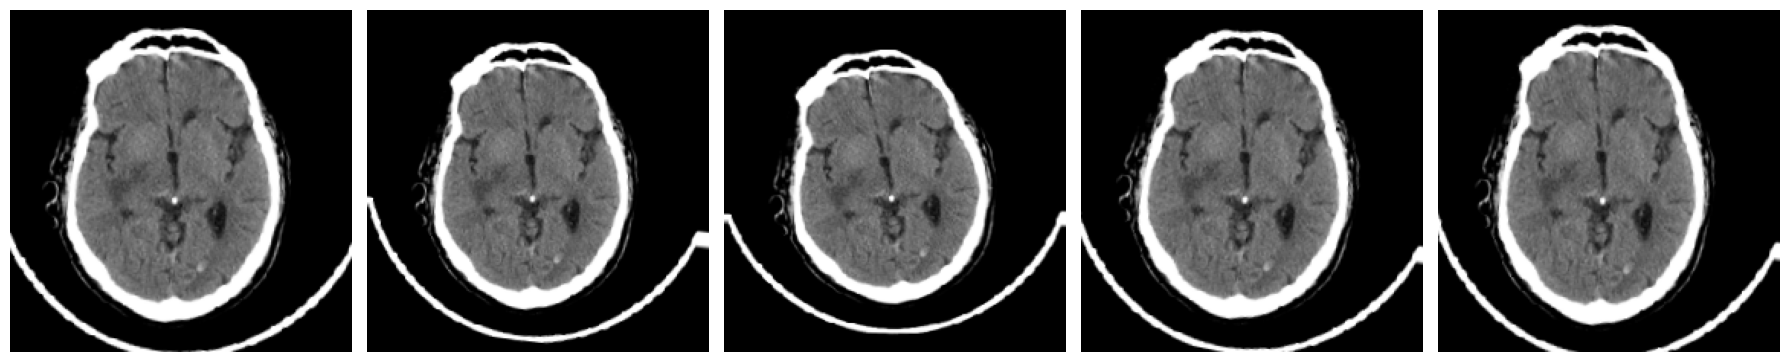

In [13]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=15,
    zoom_range=0.1,
)

train_generator = datagen.flow_from_directory(
    "RNSA-5K-PNGs/Train",
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True,
)
val_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
)


valid_generator = val_gen.flow_from_directory(
    "RNSA-5K-PNGs/Validation",
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',

)
test_generator = val_gen.flow_from_directory(
    "RNSA-5K-PNGs/Test",
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
)


def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(18,18))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
augmented_images = [train_generator[0][0][0] for i in range(5)]
plotImages(augmented_images)


In [14]:
base_model = ResNet50(weights= 'imagenet', include_top=False, input_shape= (224, 224, 3))
resnet = base_model.output
resnet = GlobalAveragePooling2D()(resnet)
resnet = Dropout(0.25)(resnet)
predictions = Dense(6, activation= 'softmax')(resnet)
Resnet50 = Model(inputs = base_model.input, outputs = predictions)

94765736/94765736 [==============================] - 4s 0us/step


In [16]:
adam = Adam(learning_rate = 0.0001)
Resnet50.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
History = Resnet50.fit(train_generator,  epochs = 30,  validation_data = valid_generator)

Epoch 1/30
660/660 [==============================] - 462s 605ms/step - loss: 1.4072 - accuracy: 0.7893 - val_loss: 1.6205 - val_accuracy: 0.6974
Epoch 2/30
660/660 [==============================] - 360s 546ms/step - loss: 1.2113 - accuracy: 0.8488 - val_loss: 1.2808 - val_accuracy: 0.8289
Epoch 3/30
660/660 [==============================] - 335s 508ms/step - loss: 1.1272 - accuracy: 0.8703 - val_loss: 1.1785 - val_accuracy: 0.8609
Epoch 4/30
660/660 [==============================] - 333s 504ms/step - loss: 1.0754 - accuracy: 0.8822 - val_loss: 1.2239 - val_accuracy: 0.8527
Epoch 5/30
660/660 [==============================] - 335s 507ms/step - loss: 1.0264 - accuracy: 0.8931 - val_loss: 1.1236 - val_accuracy: 0.8726
Epoch 6/30
660/660 [==============================] - 344s 521ms/step - loss: 0.9831 - accuracy: 0.9020 - val_loss: 1.2100 - val_accuracy: 0.8615
Epoch 7/30
660/660 [==============================] - 334s 505ms/step - loss: 0.9384 - accuracy: 0.9108 - val_loss: 1.1465 -

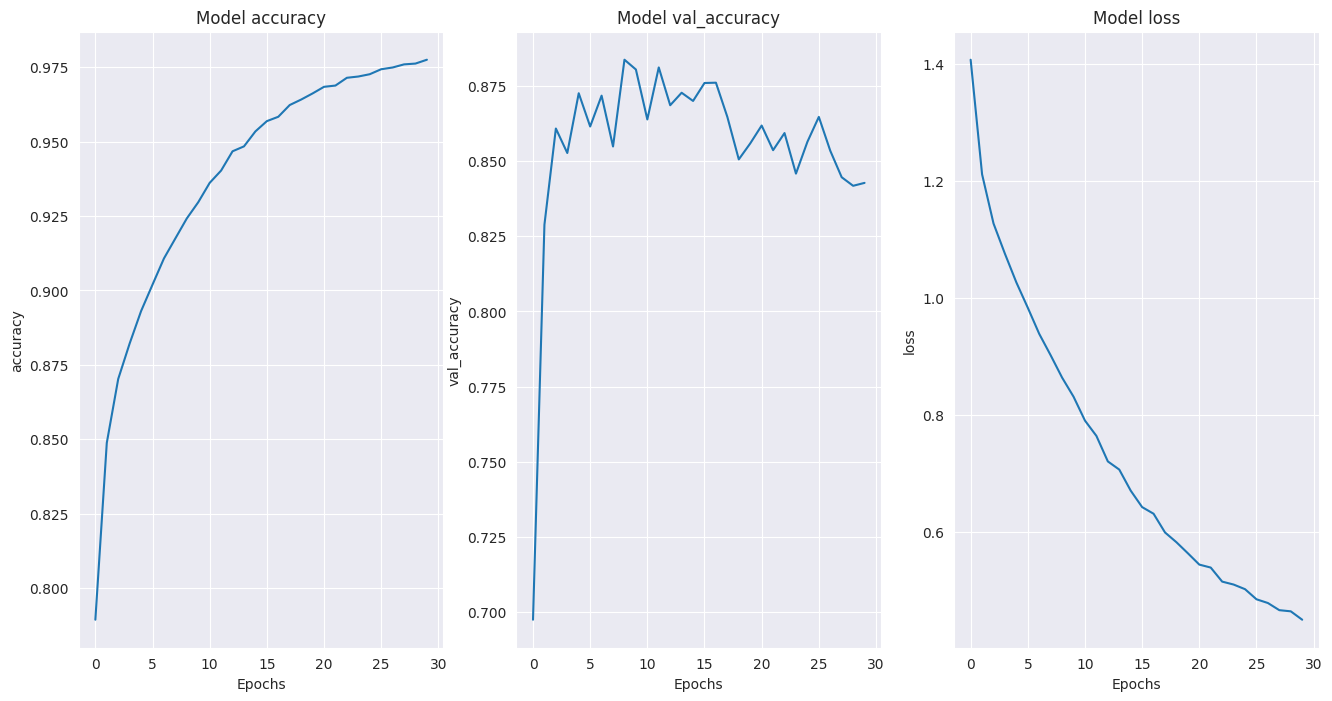

In [21]:
fig, ax = plt.subplots(1, 3, figsize = (16, 8))
ax = ax.ravel()

for i, metric in enumerate(["accuracy","val_accuracy","loss"]):
    ax[i].plot(History.history[metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)

In [22]:
classes = list(test_generator.class_indices.keys())
classes

['Any_Normal',
 'epidural_positive',
 'intraparenchymal_positvie',
 'intraventricular_positive',
 'subarachnoid_positive',
 'subdural_positive']

In [23]:
Y_pred = Resnet50.predict(test_generator)

88/88 [==============================] - 11s 113ms/step


In [24]:
y_pred = np.argmax(Y_pred, axis=1)
y_true  =test_generator.classes
target_names = classes
cm = confusion_matrix(test_generator.classes, y_pred)

In [39]:
import itertools


from sklearn.metrics import classification_report, confusion_matrix
#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
  
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    plt.figure(figsize=(10,10))
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


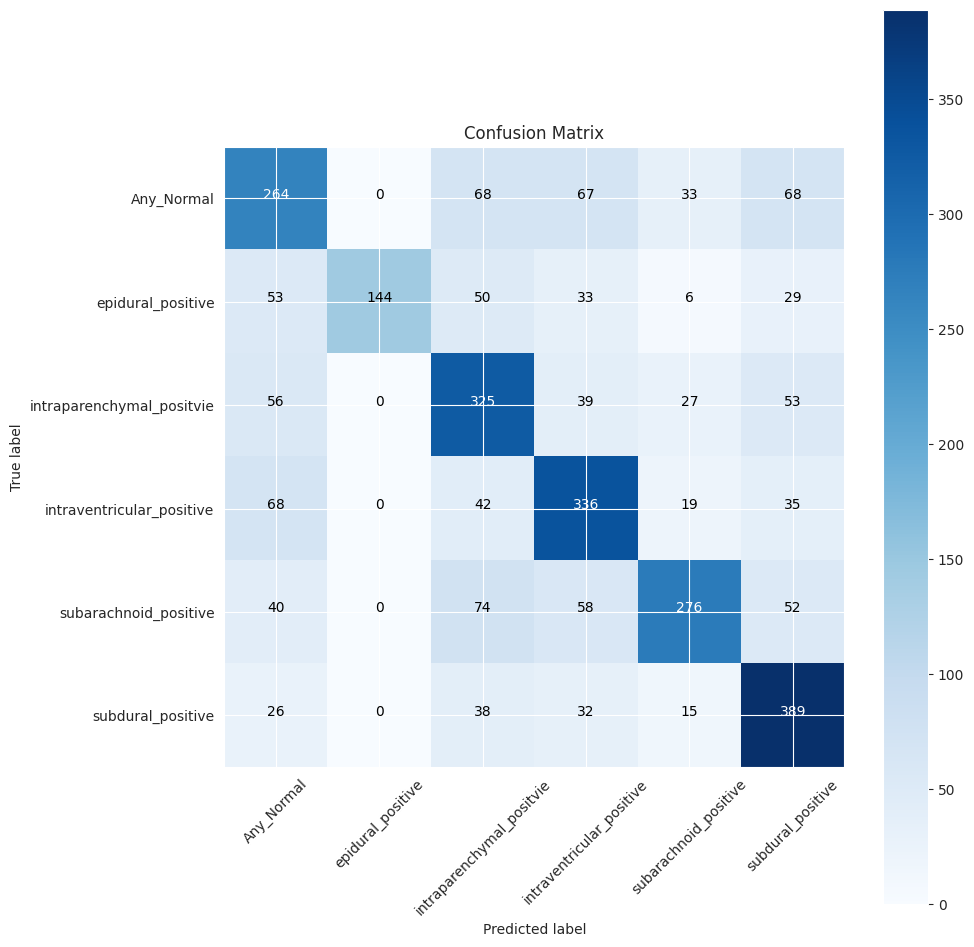

In [40]:

plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')


In [36]:
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=target_names))

Classification Report
                           precision    recall  f1-score   support

               Any_Normal       0.89      0.92      0.91       500
        epidural_positive       0.94      0.90      0.92       315
intraparenchymal_positvie       0.89      0.92      0.91       500
intraventricular_positive       0.93      0.92      0.92       500
    subarachnoid_positive       0.95      0.91      0.93       500
        subdural_positive       0.91      0.92      0.91       500

                 accuracy                           0.92      2815
                macro avg       0.92      0.92      0.92      2815
             weighted avg       0.92      0.92      0.92      2815

